#### Single Trial Analysis 
##### New Bonsai NWBs

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML
import re
from datetime import datetime
import sys
from pathlib import Path

from aind_dynamic_foraging_data_utils import nwb_utils as nu
import aind_dynamic_foraging_basic_analysis.licks.annotation as a

sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/utils')
import behavior_utils as bu
import array_utils as au
import load_utils as lu

In [30]:
foraging_filepath = '/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/foraging_trials_bonsai.csv'

foraging_df = pd.read_csv(foraging_filepath)

foraging_df

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_16073/834719624.py:3: DtypeWarning: Columns (31,38,40,42,52) have mixed types. Specify dtype option on import or set low_memory=False.
  foraging_df = pd.read_csv(foraging_filepath)


,trial,animal_response,rewarded_historyL,rewarded_historyR,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,...,reward_time_in_session,reward_time_in_trial,choice_time_in_session,choice_time_in_trial,earned_reward,extra_reward,subject_id,session_date,reward_delay,minimum_opto_interval
0,0,2.0,False,False,False,False,0.45,0.4,0.05,0.789076,...,NaN,NaN,NaN,NaN,False,False,687553,2023-12-01,NaN,NaN
1,1,2.0,False,False,False,False,0.45,0.4,0.05,0.518192,...,NaN,NaN,NaN,NaN,False,False,687553,2023-12-01,NaN,NaN
2,2,0.0,True,False,True,False,0.45,0.4,0.05,0.367511,...,16.160096,0.487072,16.153088,0.480064,True,False,687553,2023-12-01,NaN,NaN
3,3,0.0,True,False,True,False,0.45,0.4,0.05,0.053372,...,25.333088,0.376064,25.331872,0.374848,True,False,687553,2023-12-01,NaN,NaN
4,4,0.0,False,False,False,False,0.45,0.4,0.05,0.955191,...,NaN,NaN,34.364160,0.157440,False,False,687553,2023-12-01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577768,582,1.0,False,False,False,False,0.45,0.4,0.05,0.700221,...,NaN,NaN,5378.042624,0.199680,False,False,724555,2024-07-10,0.0,0.0
2577769,583,2.0,False,False,False,False,0.45,0.4,0.05,0.678467,...,NaN,NaN,NaN,NaN,False,False,724555,2024-07-10,0.0,0.0
2577770,584,1.0,False,False,True,False,0.45,0.4,0.05,0.050451,...,NaN,NaN,5392.707232,0.347424,False,False,724555,2024-07-10,0.0,0.0
2577771,585,1.0,False,False,True,False,0.45,0.4,0.05,0.118763,...,NaN,NaN,5404.919264,0.359232,False,False,724555,2024-07-10,0.0,0.0


In [7]:
# Probability chosen metric calculation 

def calculate_probabilities(row):
    # No response results in a NaN value
    if row.animal_response == 2:
        return np.nan, np.nan
    # Chosen = left choice left probability, not chosen = left choice right probability 
    elif row.animal_response == 0:
        return row.reward_probabilityL, row.reward_probabilityR
    else: # Chosen = right choice right probability, not chosen = right choice left probability 
        return row.reward_probabilityR, row.reward_probabilityL


In [8]:
# global mins and maxes need to be calculated on a stage level due to differences in probabilites between FINAL and rest
# normalize at block level 

def chosen_metric(df):
    # Calculate the difference for each row
    average = (df['probability_chosen'] - df['probability_not_chosen'])
    
    # Find global maximum
    p_larger_global = max(df['probability_chosen'].max(), df['probability_not_chosen'].max())
    
    # Find global minimum
    p_smaller_global = min(df['probability_chosen'].min(), df['probability_not_chosen'].min())
    
    # Calculate mean of the differences
    mean_difference = average.mean()
    
    # Calculate final metric
    final_metric = mean_difference / (p_larger_global - p_smaller_global)
   
    return(final_metric)

In [9]:
def process_subject_data(subject_dfs):
    """ 
    Process subject DataFrames to calculate probabilities and chosen metrics for each session / subject_id

    Params:
    subject_dfs (dict): Dictionary containing subject_id DataFrames

    Returns:
    processed_dfs (dict): Dictionary containing subject_id DataFrames with probability and chosen metrics
    """ 

    all_summaries = []

    for subject_id, subject_data in subject_dfs.items():
        # Group data by session date
        grouped_data = subject_data.groupby('session_date')

        # Initialize lists to store results 
        session_dates = []
        metrics = []
        stages = []

        for session_date, session_group in grouped_data:
            # Calculate probabilities for current session
            prob_chosen, prob_not_chosen = zip(*session_group.apply(calculate_probabilities, axis=1))

            # Create temporary dataframe to store calculations
            temp_df = pd.DataFrame({
                'probability_chosen': prob_chosen,
                'probability_not_chosen': prob_not_chosen
            })

            # Find chosen metric for this session
            session_metric = chosen_metric(temp_df)

            # Get stage for this session
            stage = session_group['auto_train_stage'].iloc[0]

            # Store result
            session_dates.append(session_date)
            metrics.append(session_metric)
            stages.append(stage)

            # Add probability columns
            subject_data.loc[session_group.index, 'probability_chosen'] = prob_chosen
            subject_data.loc[session_group.index, 'probability_not_chosen'] = prob_not_chosen

        # Create summary dataframe for this subject
        summary_df = pd.DataFrame({
            'subject_id': subject_id,
            'session_date': session_dates,
            'chosen_metric': metrics,
            'auto_train_stage': stages
        })

        summary_df = summary_df.sort_values('session_date')

        # Add session column
        summary_df['session'] = range(1, len(summary_df) + 1)

        all_summaries.append(summary_df)

    processed_df = pd.concat(all_summaries, ignore_index=True)

    return processed_df

In [10]:
processed_results = process_subject_data(subject_dfs)
processed_results['subject_id'] = processed_results['subject_id'].astype('int64')

processed_results

,subject_id,session_date,chosen_metric,auto_train_stage,session
0,711039,2024-08-07,0.359699,STAGE_2,1
1,711039,2024-08-08,0.447563,STAGE_2,2
2,711039,2024-08-09,0.317986,STAGE_2,3
3,711039,2024-08-12,0.086239,STAGE_3,4
4,711039,2024-08-14,0.293666,STAGE_3,5
...,...,...,...,...,...
310,720956,2024-05-28,0.081761,STAGE_FINAL,1
311,720956,2024-05-30,0.067797,STAGE_FINAL,2
312,720956,2024-08-08,0.102564,STAGE_FINAL,3
313,720956,2024-08-09,0.135762,STAGE_FINAL,4


In [11]:
# Load in session level metrics 

session_metrics = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv')
session_metrics['session_date'] = session_metrics['session_date'].astype('datetime64[ns]')

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_16073/1577903200.py:3: DtypeWarning: Columns (6,7,8,11,26,27,28,29,30,133,134,149,150,151,152,153,154,155,156,157,158,159,160,161) have mixed types. Specify dtype option on import or set low_memory=False.
  session_metrics = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv')


In [12]:
session_metrics['curriculum_name'].unique()

array(['Uncoupled Baiting', nan, 'Uncoupled Without Baiting',
       'Coupled Baiting'], dtype=object)

In [13]:
main_df = bu.merge_dataframes_subject_id(processed_results, session_metrics)

print(main_df['curriculum_name'].unique())

main_df

['Uncoupled Without Baiting' 'Uncoupled Baiting' 'Coupled Baiting']


,subject_id,session_date,chosen_metric,auto_train_stage,session_x,nwb_suffix,session_y,rig,user_name,curriculum_name,...,subject_genotype,fiber_probes,injections,task_type,virus,NM_recorded,results,results_location,session_time,docDB_status
0,711039,2024-08-07,0.359699,STAGE_2,1,93549,4.0,447-2-D,Henry Loeffler,Uncoupled Without Baiting,...,Dbh-Cre-KI/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...",[{'injection_materials': ['pAAV-syn-FLEX-jGCaM...,Coupled Without Baiting,"['pAAV-syn-FLEX-jGCaMP8m-WPRE', 'pAAV-syn-FLEX...","['-5.2,0.85,-3.1', '-5.2,-0.85,-3.1']",behavior_711039_2024-08-07_09-35-49_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/9...,09-35-49,2_uploaded and processed
1,711039,2024-08-08,0.447563,STAGE_2,2,93705,5.0,447-2-D,Henry Loeffler,Uncoupled Without Baiting,...,Dbh-Cre-KI/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...",[{'injection_materials': ['pAAV-syn-FLEX-jGCaM...,Coupled Without Baiting,"['pAAV-syn-FLEX-jGCaMP8m-WPRE', 'pAAV-syn-FLEX...","['-5.2,0.85,-3.1', '-5.2,-0.85,-3.1']",behavior_711039_2024-08-08_09-37-05_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/3...,09-37-05,2_uploaded and processed
2,711039,2024-08-09,0.317986,STAGE_2,3,92544,6.0,447-2-D,Henry Loeffler,Uncoupled Without Baiting,...,Dbh-Cre-KI/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...",[{'injection_materials': ['pAAV-syn-FLEX-jGCaM...,Coupled Without Baiting,"['pAAV-syn-FLEX-jGCaMP8m-WPRE', 'pAAV-syn-FLEX...","['-5.2,0.85,-3.1', '-5.2,-0.85,-3.1']",behavior_711039_2024-08-09_09-25-44_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/6...,09-25-44,2_uploaded and processed
3,711039,2024-08-12,0.086239,STAGE_3,4,94113,7.0,447-2-D,Henry Loeffler,Uncoupled Without Baiting,...,Dbh-Cre-KI/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...",[{'injection_materials': ['pAAV-syn-FLEX-jGCaM...,Coupled Without Baiting,"['pAAV-syn-FLEX-jGCaMP8m-WPRE', 'pAAV-syn-FLEX...","['-5.2,0.85,-3.1', '-5.2,-0.85,-3.1']",behavior_711039_2024-08-12_09-41-13_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/a...,09-41-13,2_uploaded and processed
4,711039,2024-08-14,0.293666,STAGE_3,5,94523,8.0,447-2-D,Henry Loeffler,Uncoupled Without Baiting,...,Dbh-Cre-KI/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...",[{'injection_materials': ['pAAV-syn-FLEX-jGCaM...,Coupled Without Baiting,"['pAAV-syn-FLEX-jGCaMP8m-WPRE', 'pAAV-syn-FLEX...","['-5.2,0.85,-3.1', '-5.2,-0.85,-3.1']",behavior_711039_2024-08-14_09-45-23_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/8...,09-45-23,2_uploaded and processed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,720956,2024-05-28,0.081761,STAGE_FINAL,1,103112,10.0,447-1-C,Travis Ramirez,Uncoupled Baiting,...,wt/wt,"[{'angle': '-15.0', 'angle_unit': 'degrees', '...",[],Uncoupled Baiting,[],[],behavior_720956_2024-05-28_10-31-12_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/a...,10-31-12,2_uploaded and processed
311,720956,2024-05-30,0.067797,STAGE_FINAL,2,112524,12.0,447-1-C,Travis Ramirez,Uncoupled Baiting,...,wt/wt,"[{'angle': '-15.0', 'angle_unit': 'degrees', '...",[],Uncoupled Baiting,[],[],behavior_720956_2024-05-30_11-25-24_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/f...,11-25-24,2_uploaded and processed
312,720956,2024-08-08,0.102564,STAGE_FINAL,3,132911,50.0,447-3-C,Jaimie Kenney,Uncoupled Baiting,...,wt/wt,"[{'angle': '-15.0', 'angle_unit': 'degrees', '...",[],Uncoupled Baiting,[],[],behavior_720956_2024-08-08_13-29-11_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/6...,13-29-11,2_uploaded and processed
313,720956,2024-08-09,0.135762,STAGE_FINAL,4,132822,51.0,447-3-C,Jaimie Kenney,Uncoupled Baiting,...,wt/wt,"[{'angle': '-15.0', 'angle_unit': 'degrees', '...",[],Uncoupled Baiting,[],[],behavior_720956_2024-08-09_13-28-22_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/4...,13-28-22,2_uploaded and processed


In [14]:
curriculum = 'Coupled Baiting'

main_df = main_df[main_df['curriculum_name'] == curriculum]

main_df

,subject_id,session_date,chosen_metric,auto_train_stage,session_x,nwb_suffix,session_y,rig,user_name,curriculum_name,...,subject_genotype,fiber_probes,injections,task_type,virus,NM_recorded,results,results_location,session_time,docDB_status
63,708027,2024-08-07,0.115243,STAGE_FINAL,1,133305,7.0,447-2-D,Jaimie Kenney,Coupled Baiting,...,Slc6a3-IRES-Cre_Bkmn/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...",[{'injection_materials': ['AiV300091 v153886']...,Coupled Baiting,"['AiV300091 v153886', 'AiV300128 VT5968G']",[],behavior_708027_2024-08-07_13-33-05_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/5...,13-33-05,2_uploaded and processed
64,708027,2024-08-08,0.147105,STAGE_FINAL,2,133822,8.0,447-2-D,Jaimie Kenney,Coupled Baiting,...,Slc6a3-IRES-Cre_Bkmn/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...",[{'injection_materials': ['AiV300091 v153886']...,Coupled Baiting,"['AiV300091 v153886', 'AiV300128 VT5968G']",[],behavior_708027_2024-08-08_13-38-22_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/2...,13-38-22,2_uploaded and processed
65,708027,2024-08-09,-0.004255,STAGE_FINAL,3,133535,9.0,447-2-D,Jaimie Kenney,Coupled Baiting,...,Slc6a3-IRES-Cre_Bkmn/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...",[{'injection_materials': ['AiV300091 v153886']...,Coupled Baiting,"['AiV300091 v153886', 'AiV300128 VT5968G']",[],behavior_708027_2024-08-09_13-35-35_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/a...,13-35-35,2_uploaded and processed
66,708027,2024-08-12,-0.022824,STAGE_FINAL,4,130451,10.0,447-2-D,Jaimie Kenney,Coupled Baiting,...,Slc6a3-IRES-Cre_Bkmn/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...",[{'injection_materials': ['AiV300091 v153886']...,Coupled Baiting,"['AiV300091 v153886', 'AiV300128 VT5968G']",[],behavior_708027_2024-08-12_13-04-51_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/1...,13-04-51,2_uploaded and processed
67,708027,2024-08-15,0.168224,STAGE_FINAL,5,124142,12.0,447-2-D,Jaimie Kenney,Coupled Baiting,...,Slc6a3-IRES-Cre_Bkmn/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...",[{'injection_materials': ['AiV300091 v153886']...,Coupled Baiting,"['AiV300091 v153886', 'AiV300128 VT5968G']",[],behavior_708027_2024-08-15_12-41-42_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/3...,12-41-42,2_uploaded and processed
68,708027,2024-08-16,0.142292,STAGE_3,6,122451,13.0,447-2-D,Jaimie Kenney,Coupled Baiting,...,Slc6a3-IRES-Cre_Bkmn/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...",[{'injection_materials': ['AiV300091 v153886']...,Coupled Baiting,"['AiV300091 v153886', 'AiV300128 VT5968G']",[],behavior_708027_2024-08-16_12-24-51_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/1...,12-24-51,2_uploaded and processed
69,708027,2024-08-19,0.299487,STAGE_FINAL,7,133909,14.0,447-2-D,Jaimie Kenney,Coupled Baiting,...,Slc6a3-IRES-Cre_Bkmn/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...",[{'injection_materials': ['AiV300091 v153886']...,Coupled Baiting,"['AiV300091 v153886', 'AiV300128 VT5968G']",[],behavior_708027_2024-08-19_13-39-09_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/b...,13-39-09,2_uploaded and processed
70,708027,2024-08-20,0.091300,STAGE_FINAL,8,133510,15.0,447-2-D,Jaimie Kenney,Coupled Baiting,...,Slc6a3-IRES-Cre_Bkmn/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...",[{'injection_materials': ['AiV300091 v153886']...,Coupled Baiting,"['AiV300091 v153886', 'AiV300128 VT5968G']",[],behavior_708027_2024-08-20_13-35-10_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/f...,13-35-10,2_uploaded and processed
71,708027,2024-08-21,0.090680,STAGE_FINAL,9,133501,16.0,447-2-D,Jaimie Kenney,Coupled Baiting,...,Slc6a3-IRES-Cre_Bkmn/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...",[{'injection_materials': ['AiV300091 v153886']...,Coupled Baiting,"['AiV300091 v153886', 'AiV300128 VT5968G']",[],behavior_708027_2024-08-21_13-35-01_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/0...,

In [15]:
main_df['auto_train_stage'].unique()

array(['STAGE_FINAL', 'STAGE_3', 'STAGE_1'], dtype=object)

<Axes: xlabel='session_x', ylabel='chosen_metric'>

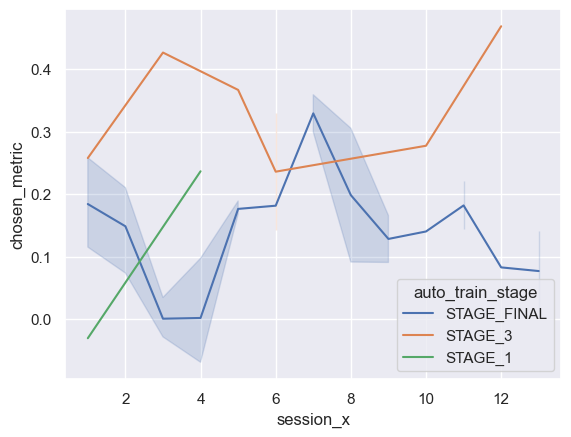

In [16]:
sns.lineplot(main_df, x='session_x', y='chosen_metric', hue='auto_train_stage')